Analyze street graph
====================
Loads a street graph and produces its metrics

In [5]:
import snman
from snman import osmnx_customized as oxc
from snman.constants import *
import geopandas as gpd
import matplotlib.pyplot as plt

PERIMETER = '_debug'

# Set these paths according to your own setup
data_directory = 'C:/Users/lballo/polybox/Research/SNMan/SNMan Shared/data_v2/'
inputs_path = data_directory + 'inputs/'
source_path = data_directory + 'outputs/' + PERIMETER + '/'
export_path = data_directory + 'metrics/' + '_debug' + '/'

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [6]:
# =====================================================================================
# LOAD DATA
# =====================================================================================

print('Load street graph')
G = snman.io.load_street_graph(source_path + 'street_graph_edges.gpkg', source_path + 'street_graph_nodes.gpkg')

Load street graph


<Axes: xlabel='ln_desc_after'>

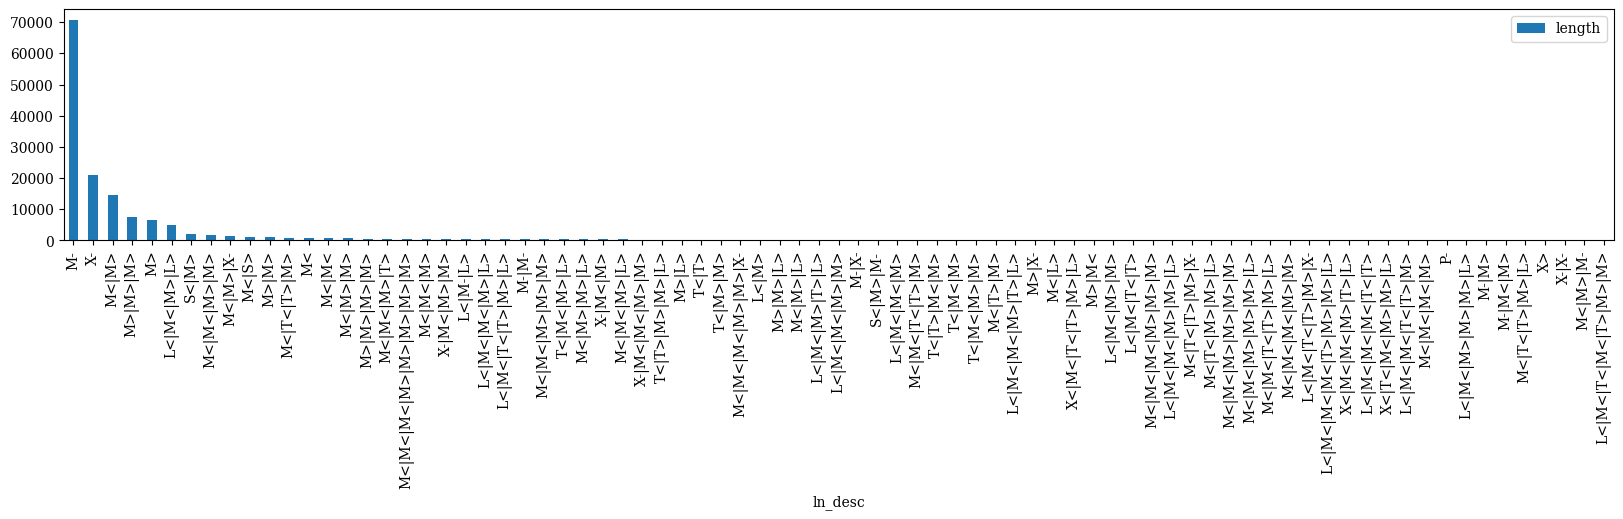

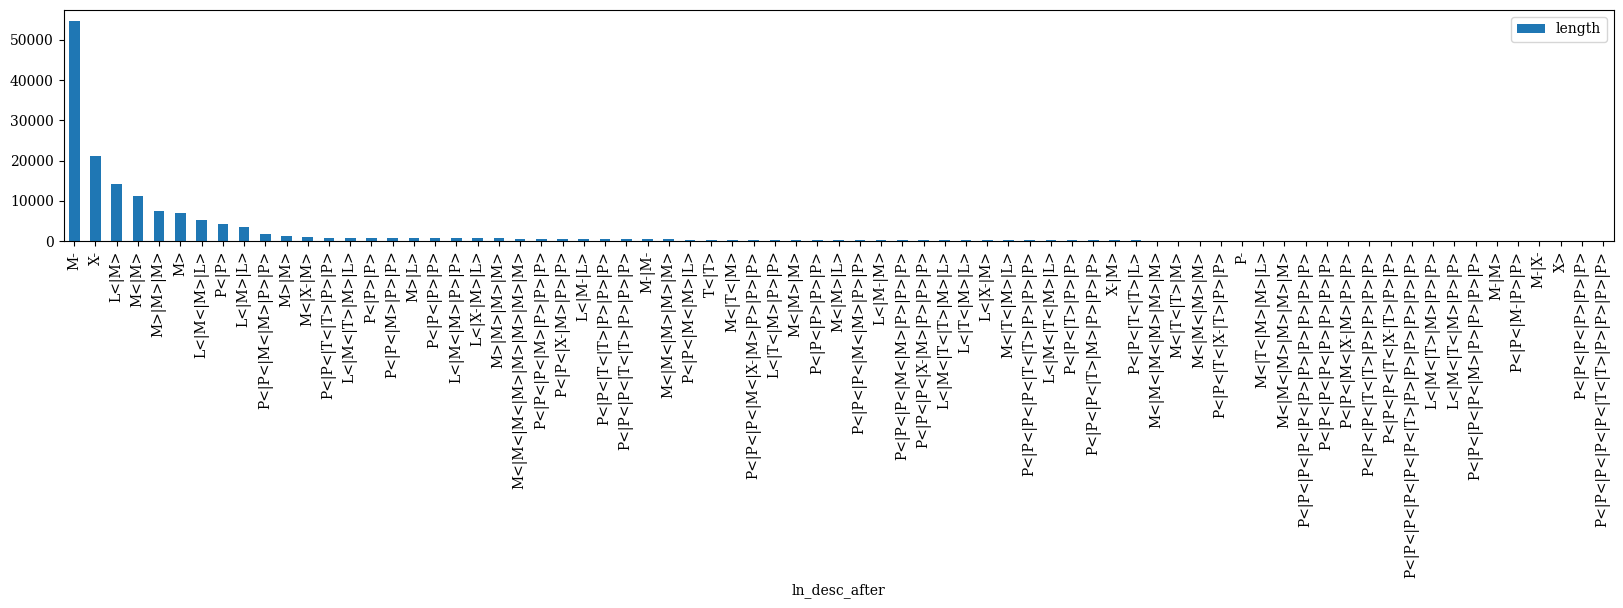

In [58]:
# Sections histogram
sections_before = snman.stats.street_sections(G, key_lanes_description=KEY_LANES_DESCRIPTION)
sections_after = snman.stats.street_sections(G, key_lanes_description=KEY_LANES_DESCRIPTION_AFTER)
sections_before.plot(kind='bar', figsize=(20,3))
sections_after.plot(kind='bar', figsize=(20,3))

<Axes: xlabel='ln_desc'>

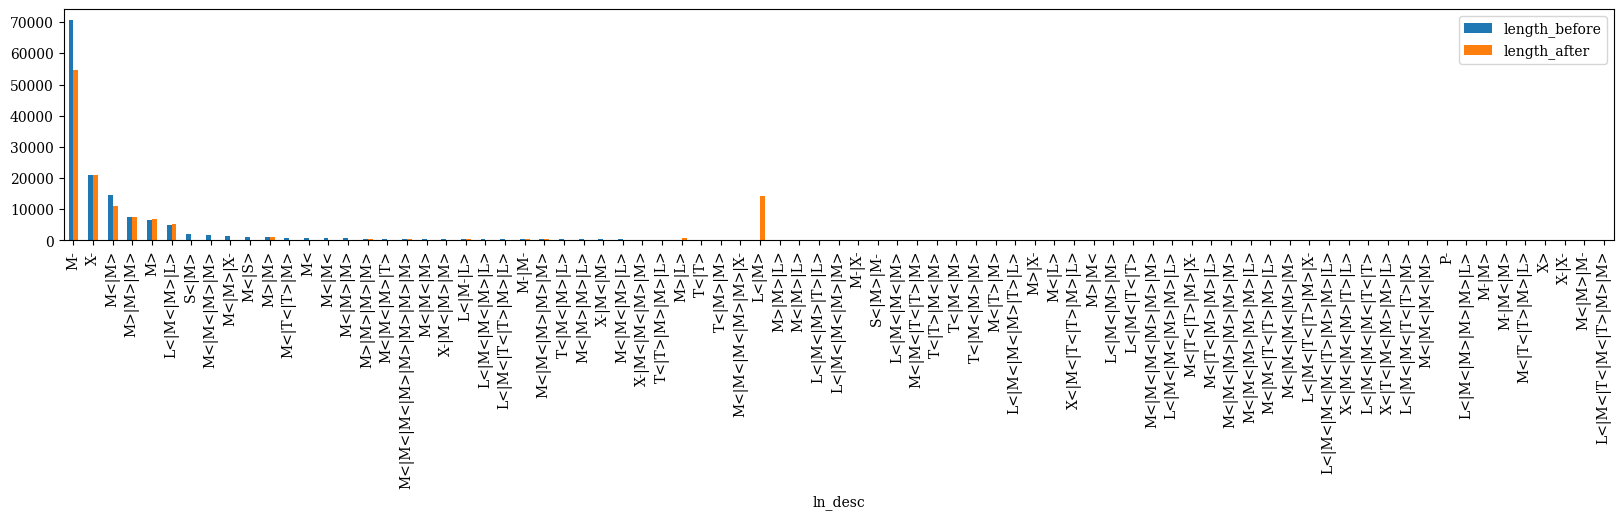

In [59]:
# Sections before after comparison
a = sections_before.join(sections_after, lsuffix='_before', rsuffix='_after').fillna(0)
a.plot(kind='bar', figsize=(20,3))

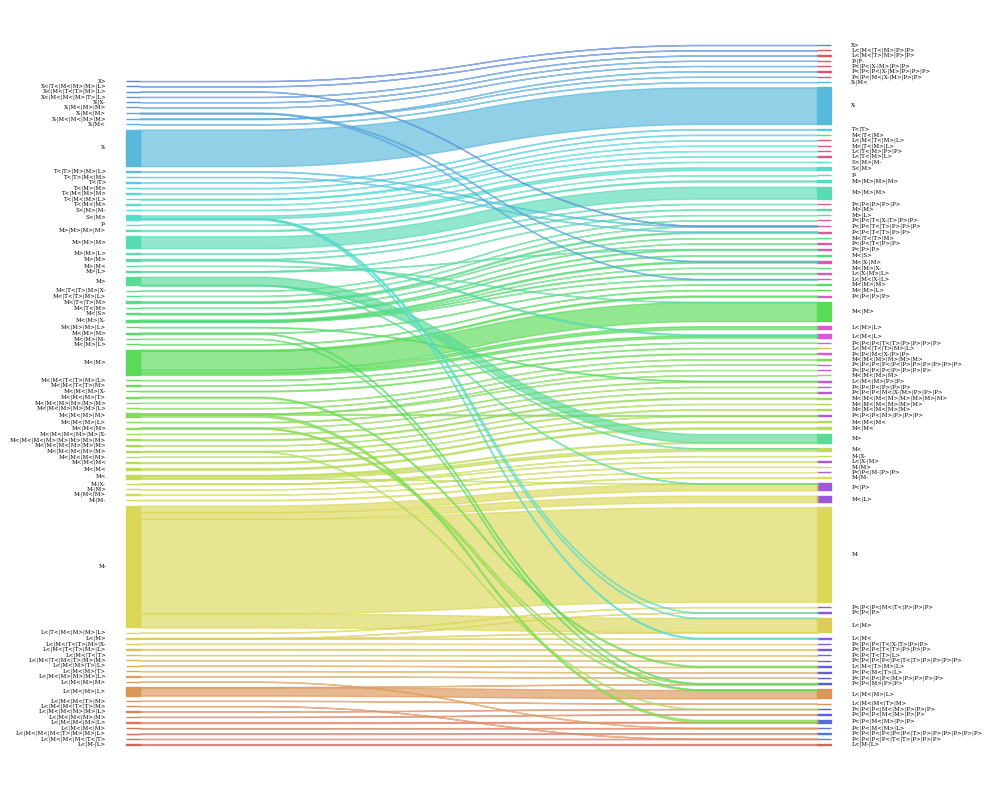

In [62]:
# Sections transformation flows

from pySankey.sankey import sankey

nodes, edges = oxc.graph_to_gdfs(G, nodes=True, edges=True)

edges[KEY_LANES_DESCRIPTION] = edges[KEY_LANES_DESCRIPTION].apply(lambda x: '|'.join(x))
edges[KEY_LANES_DESCRIPTION_AFTER] = edges[KEY_LANES_DESCRIPTION_AFTER].apply(lambda x: '|'.join(x))

flows = edges[[KEY_LANES_DESCRIPTION, KEY_LANES_DESCRIPTION_AFTER, 'length']].groupby([KEY_LANES_DESCRIPTION, KEY_LANES_DESCRIPTION_AFTER]).sum('length')
flows = flows.reset_index()

sankey(
    left=flows['ln_desc'], right=flows['ln_desc_after'],
    leftWeight= flows['length'], rightWeight=flows['length'],
    fontsize=4, closePlot=False
)
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_facecolor("w")
fig.savefig(export_path + 'space_allocation_sankey.png', bbox_inches="tight", dpi=300)

In [ ]:
L = snman.graph_tools.street_graph_to_lane_graph(G, MODE_CYCLING, KEY_LANES_DESCRIPTION_AFTER)

# Snap POIs
nodes = oxc.graph_to_gdfs(L, edges=False)
nodes['node_geom'] = nodes.geometry
snapped_poi_gpd = gpd.sjoin_nearest(poi_gpd, nodes, how='inner', max_distance=1000)[['index_right','node_geom']]\
    .rename(columns={'node_geom':'geometry'}).set_geometry('geometry').set_index('index_right')


# Cost List

import itertools as it
import shapely as shp
import pandas as pd

ods = it.permutations(snapped_poi_gpd.index, 2)
a = gpd.GeoDataFrame(ods, columns=['origin', 'destination'])

a['origin_geom'] = snapped_poi_gpd.merge(a, left_index=True, right_on='origin')['geometry']
a['destination_geom'] = snapped_poi_gpd.merge(a, left_index=True, right_on='destination')['geometry']
a['od_line_geom'] = a.apply(
    lambda row: shp.LineString([row['origin_geom'], row['destination_geom']]),
    axis=1).set_crs(2056)
a['cost'] = a.apply(
    lambda row: nx.shortest_path_length(L, source=row['origin'], target=row['destination'], weight='cost'),
    axis=1)
a['od_path_geom'] = a.apply(
    lambda row: shp.LineString(
        nodes.loc[nx.shortest_path(L, source=row['origin'], target=row['destination'], weight='cost')]['geometry'])
    ,axis=1).set_crs(2056)

a_complete = a
a = a[['origin', 'destination', 'cost', 'od_path_geom']]
a = a.set_geometry('od_path_geom')
a.to_file(export_path + 'od.gpkg')

# List of Points
snapped_poi_gpd.to_file(export_path + 'cartogram_points.gpkg')

# OD Matrix
M = pd.DataFrame(index=snapped_poi_gpd.index, columns=snapped_poi_gpd.index)
M.index.name = None

for idx, row in a.iterrows():
    M.loc[row['origin'], row['destination']] = row['cost']
    M.loc[row['origin'], row['origin']] = 0
    M.loc[row['destination'], row['destination']] = 0

M.to_csv(export_path + 'od.csv')

In [ ]:

H = oxc.truncate.truncate_graph_polygon(
    G,
    measurement_regions_gdf.loc[0].geometry,
    quadrat_width=100,
    retain_all=True
)


In [ ]:
import networkx as nx

L = snman.street_graph.to_lane_graph(H, MODE_TRANSIT, KEY_LANES_DESCRIPTION_AFTER)

# Calculate strongly connected components
components = list(nx.strongly_connected_components(L))

# Assign a different color to each component
colors = {}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# Draw the graph with nodes colored by component
oxc.plot_graph(L, node_color=[colors[node] for node in L.nodes()])

In [ ]:
import pandas as pd

res = pd.DataFrame([
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_PRIVATE_CARS, KEY_LANES_DESCRIPTION)
            , weak=False
        )
    ),
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_PRIVATE_CARS, KEY_LANES_DESCRIPTION_AFTER)
            , weak=False
        )
    ),
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_CYCLING, KEY_LANES_DESCRIPTION)
            , weak=False
        )
    ),
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_CYCLING, KEY_LANES_DESCRIPTION_AFTER)
            , weak=False
        )
    ),
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_TRANSIT, KEY_LANES_DESCRIPTION)
            , weak=False
        )
    ),
    snman.lane_graph.calculate_stats(
        snman.graph_utils.keep_only_the_largest_connected_component(
            snman.street_graph.to_lane_graph(H, MODE_TRANSIT, KEY_LANES_DESCRIPTION_AFTER)
            , weak=False
        )
    )
])

res['mode'] = [MODE_PRIVATE_CARS, MODE_PRIVATE_CARS, MODE_CYCLING, MODE_CYCLING, MODE_TRANSIT, MODE_TRANSIT]
res['situation'] = ['before', 'after', 'before', 'after', 'before', 'after']

res = res.set_index(['mode', 'situation']).transpose()
res